# Introduction:

This last competition tested most of the kagglers in terms of data engineering skills, which proved to be the worst obstacle in terms of calculation performance, and also in terms of data signal extrapolation, which is important to understand what should or should not be done in data preprocessing.

# Objective:

Provide the less experienced with a detailed analysis (I hope) of the AMEX data preprocessing that was used for this competition. The data engineering was more or less extrapolated from the GM Kagglers, but I have also added my own function.

# What I did:

* I loaded the very useful database in parquet format from [Raddar](https://www.kaggle.com/datasets/raddar/amex-data-integer-dtypes-parquet-format).

* I explained step by step the preprocessing of data on a DEMO dataset. Skip it if you're not interested.

* I created the custom functions. Some come from the notebook of [MARTIN KOVACEVIC BUVINIC](https://www.kaggle.com/code/ragnar123/amex-lgbm-dart-cv-0-7977#Comments:). Compared to the latter I added a function to remove noise from the data and a loop to remove categorical columns with only ONE value.

* I preprocessed not all the columns (about 190) but separately according to the type of variables: payment variables, risk variables, balance variables, delinquency variables, and spend variables. In total, we have 5 preprocessing functions. I did this because running preprocessing on the entire dataset would have crashed the kernel due to RAM limitations. In addition, to speed up some calculations, I used **cuDF** (which works on GPU).

* I saved the files on disk in parquet format. These can be used to experiment with different models.

# Next experiments:

* Applying preprocessing on data grouped by month.

# Importing Libraries

In [1]:
import gc
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import cudf
import time


import warnings 
warnings.filterwarnings('ignore')

# Loding demo dataset

In [2]:
start = time.time()
demo_df = cudf.read_parquet('../input/amex-data-integer-dtypes-parquet-format/train.parquet', columns = ["customer_ID","P_2","P_3","B_30","B_38"])
print("no. of rows in the demo_df", demo_df.shape[0])
print("no. of columns in the demo_df", demo_df.shape[1])
end = time.time()
print("GPU time= ", end-start)

no. of rows in the demo_df 5531451
no. of columns in the demo_df 5
GPU time=  3.976944923400879


**cuDF data type supported**

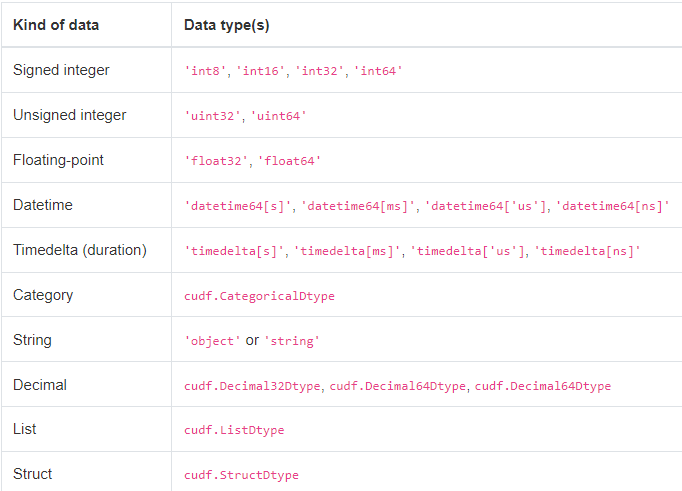

source: [RAPIDS](https://docs.rapids.ai/api/cudf/stable/user_guide/data-types.html)

# DATA PREPROCESSING (demo dataset)

In the [RADDAR](https://www.kaggle.com/datasets/raddar/amex-data-integer-dtypes-parquet-format) dataset *int* columns do not support NA values, so NA was converted with -1

**(1) Select only 1000 rows and read data information.**

In [3]:
demo_df = demo_df.loc[0:1000,:]
print(demo_df.info(memory_usage='deep'))

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   customer_ID  1001 non-null   object
 1   P_2          999 non-null    float32
 2   P_3          953 non-null    float32
 3   B_30         1001 non-null   int8
 4   B_38         1001 non-null   int8
dtypes: float32(2), int8(2), object(1)
memory usage: 76.5 KB
None


int8: nteger type that uses 1 byte per data element and can store values in the range -127 .. 127. Most arithmetic operations involving this type will produce a result of type int32, which follows the convention of the C language.

**(2) Select categorical and numerical features.**

In [4]:
features = demo_df.drop("customer_ID",axis = 1).columns.to_list()
cat_features = ["B_30","B_38"]
num_features = [col for col in features if col not in cat_features] #extracts only column names

**(3) Aggregation using one or more operations on the specified axis of the NUMERICAL FEATURES. This step is useful for adding new features to our dataset, so that we can add some information to our model.**

For this operation we will use **cuDF**

**NOTE:** Setting **sort=True** will produce Pandas-like output, but with some performance penalty:

In [6]:
# Adding functions of interest (numerical features)
num_function = ['mean', 'std', 'min', 'max', 'last']
demo_df_num_agg = demo_df.groupby("customer_ID", sort = True)[num_features].agg(num_function)
demo_df_num_agg.head()

P_2            \
                                                        mean       std   
customer_ID                                                              
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fb...  0.933824  0.024194   
00000fd6641609c6ece5454664794f0340ad84dddce9a26...  0.899820  0.022119   
00001b22f846c82c51f6e3958ccd81970162bae8b007e80...  0.878454  0.028911   
000041bdba6ecadd89a52d11886e8eaaec9325906c97233...  0.598969  0.020107   
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad...  0.891679  0.042325   

                                                                        \
                                                         min       max   
customer_ID                                                              
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fb...  0.868580  0.960384   
00000fd6641609c6ece5454664794f0340ad84dddce9a26...  0.861109  0.929122   
00001b22f846c82c51f6e3958ccd81970162bae8b007e80...  0.797670  0.904482   
000041bdba6ecadd89a52d11886e8eaaec9325906c97233...  0.567442  0.623392   
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad...  0.805045  0.940382   

                                                                   P_3  \
                                                        last      mean   
customer_ID                                                              
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fb...  0.934745  0.680138   
00000fd6641609c6ece5454664794f0340ad84dddce9a26...  0.880519  0.566665   
00001b22f846c82c51f6e3958ccd81970162bae8b007e80...  0.880875  0.618191   
000041bdba6ecadd89a52d11886e8eaaec9325906c97233...  0.621776  0.610934   
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad...  0.871900  0.527254   

                                                                        \
                                                         std       min   
customer_ID                                                              
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fb...  0.050671  0.581678   
00000fd6641609c6ece5454664794f0340ad84dddce9a26...  0.036880  0.510142   
00001b22f846c82c51f6e3958ccd81970162bae8b007e80...  0.075604  0.381123   
000041bdba6ecadd89a52d11886e8eaaec9325906c97233...  0.090090  0.345100   
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad...  0.088509  0.254276   

                                                                        
                                                         max      last  
customer_ID                                                             
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fb...  0.741813  0.629392  
00000fd6641609c6ece5454664794f0340ad84dddce9a26...  0.619012  0.570898  
00001b22f846c82c51f6e3958ccd81970162bae8b007e80...  0.678706  0.628938  
000041bdba6ecadd89a52d11886e8eaaec9325906c97233...  0.704214  0.672080  
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad...  0.584359  0.570419

**(4) Join the name of the main column (P_2 and P_3) to the respective names of the measures (mean, std etc.)**

In [7]:
demo_df_num_agg.columns = ['_'.join(x) for x in demo_df_num_agg.columns]
demo_df_num_agg.reset_index(inplace = True)
demo_df_num_agg.head()

,customer_ID,P_2_mean,P_2_std,P_2_min,P_2_max,P_2_last,P_3_mean,P_3_std,P_3_min,P_3_max,P_3_last
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.933824,0.024194,0.868580,0.960384,0.934745,0.680138,0.050671,0.581678,0.741813,0.629392
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0.899820,0.022119,0.861109,0.929122,0.880519,0.566665,0.036880,0.510142,0.619012,0.570898
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0.878454,0.028911,0.797670,0.904482,0.880875,0.618191,0.075604,0.381123,0.678706,0.628938
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,0.598969,0.020107,0.567442,0.623392,0.621776,0.610934,0.090090,0.345100,0.704214,0.672080
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,0.891679,0.042325,0.805045,0.940382,0.871900,0.527254,0.088509,0.254276,0.584359,0.570419


**(5) Aggregation using one or more operations on the specified axis of the CATEGORICAL FEATURES. This step is useful for adding new features to our dataset, so that we can add some information to our model**

For this operation we will use **cuDF**

**NOTE:** Setting **sort=True** will produce Pandas-like output, but with some performance penalty:

In [8]:
# Adding functions of interest (categorical features)
cat_function = ['count', 'last', 'nunique']
demo_df_cat_agg = demo_df.groupby("customer_ID", sort = True)[cat_features].agg(cat_function)
demo_df_cat_agg.head()

B_30               B_38  \
                                                   count last nunique count   
customer_ID                                                                   
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fb...    13    0       1    13   
00000fd6641609c6ece5454664794f0340ad84dddce9a26...    13    0       1    13   
00001b22f846c82c51f6e3958ccd81970162bae8b007e80...    13    0       1    13   
000041bdba6ecadd89a52d11886e8eaaec9325906c97233...    13    0       1    13   
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad...    13    0       1    13   

                                                                 
                                                   last nunique  
customer_ID                                                      
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fb...    2       1  
00000fd6641609c6ece5454664794f0340ad84dddce9a26...    2       1  
00001b22f846c82c51f6e3958ccd81970162bae8b007e80...    1       1  
000041bdba6ecadd89a52d11886e8eaaec9325906c97233...    2       1  
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad...    1       2

**(6) Join the name of the main column (B_30 and B_38) to the respective names of the measures (count, last etc.)**

In [9]:
demo_df_cat_agg.columns = ['_'.join(x) for x in demo_df_cat_agg.columns]
demo_df_cat_agg.reset_index(inplace = True)
demo_df_cat_agg.head()

,customer_ID,B_30_count,B_30_last,B_30_nunique,B_38_count,B_38_last,B_38_nunique
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,13,0,1,13,2,1
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,13,0,1,13,2,1
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,13,0,1,13,1,1
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,13,0,1,13,2,1
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,13,0,1,13,1,2


**Remove columns with ONE single value as it would be useless for the model training**

In [10]:
# Remove columns with ONE single value
for col in demo_df_cat_agg.drop("customer_ID", axis = 1).columns:
    if len(demo_df_cat_agg[col].unique()) == 1:
        demo_df_cat_agg.drop(col,inplace=True,axis=1)
        
demo_df_cat_agg.head()        

,customer_ID,B_30_count,B_30_last,B_30_nunique,B_38_count,B_38_last,B_38_nunique
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,13,0,1,13,2,1
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,13,0,1,13,2,1
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,13,0,1,13,1,1
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,13,0,1,13,2,1
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,13,0,1,13,1,2


**(7) Convert float64 columns to float32, and int64 or int32 to int16. Usually some data types remain unchanged when we perform the calculations, but other times this does not happen. However, tqdm is a library in Python which is used for creating Progress Meters or Progress Bars** 

In [11]:
print(demo_df_num_agg.info(memory_usage='deep'))
print(demo_df_cat_agg.info(memory_usage='deep'))

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 83 entries, 0 to 82
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   customer_ID  83 non-null     object
 1   P_2_mean     83 non-null     float64
 2   P_2_std      82 non-null     float64
 3   P_2_min      83 non-null     float32
 4   P_2_max      83 non-null     float32
 5   P_2_last     83 non-null     float32
 6   P_3_mean     79 non-null     float64
 7   P_3_std      79 non-null     float64
 8   P_3_min      79 non-null     float32
 9   P_3_max      79 non-null     float32
 10  P_3_last     79 non-null     float32
dtypes: float32(6), float64(4), object(1)
memory usage: 10.4 KB
None
<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 83 entries, 0 to 82
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   customer_ID   83 non-null     object
 1   B_30_count    83 non-null     int32
 2   B_30_last  

**TABLE:**

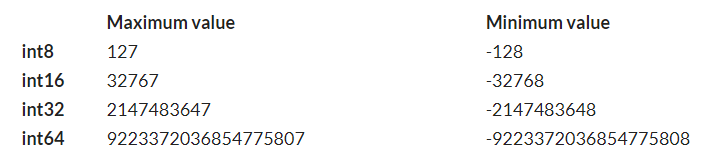

To free up RAM, we convert int32 values to int8 values; however, remember that we must be careful in these procedures, especially when converting float values

In [12]:
# Transform float64 columns to float32 
cols = list(demo_df_num_agg.dtypes[demo_df_num_agg.dtypes == 'float64'].index)
for col in tqdm(cols):
        demo_df_num_agg[col] = demo_df_num_agg[col].astype(np.float32)
# Transform int32 or int8 columns to int16
cols = list(demo_df_cat_agg.dtypes[(demo_df_cat_agg.dtypes == 'int64') | (demo_df_cat_agg.dtypes == 'int8')].index)
for col in tqdm(cols):
        demo_df_cat_agg[col] = demo_df_cat_agg[col].astype(np.int16)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [13]:
print(demo_df_num_agg.info(memory_usage='deep'))
print(demo_df_cat_agg.info(memory_usage='deep'))

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 83 entries, 0 to 82
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   customer_ID  83 non-null     object
 1   P_2_mean     83 non-null     float32
 2   P_2_std      82 non-null     float32
 3   P_2_min      83 non-null     float32
 4   P_2_max      83 non-null     float32
 5   P_2_last     83 non-null     float32
 6   P_3_mean     79 non-null     float32
 7   P_3_std      79 non-null     float32
 8   P_3_min      79 non-null     float32
 9   P_3_max      79 non-null     float32
 10  P_3_last     79 non-null     float32
dtypes: float32(10), object(1)
memory usage: 9.1 KB
None
<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 83 entries, 0 to 82
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   customer_ID   83 non-null     object
 1   B_30_count    83 non-null     int32
 2   B_30_last     83 non-nu

**(8) Get the difference. The source of the following code comes from the notebook of [MARTIN KOVACEVIC BUVINIC](https://www.kaggle.com/code/ragnar123/amex-lgbm-dart-cv-0-7977). Apologies in advance if I have not referenced other kagglers.**

cuDF's *diff* function with respect to pandas does not handle NaN values during this operation. We have no intention of filling in these values before proceeding, so we transform the cuDF dataset back to pandas

In [14]:
demo_df = demo_df.to_pandas()
df1 = []
customer_ids = []
for customer_id, df in tqdm(demo_df.groupby(['customer_ID'], sort = True)):
        # Get the differences
        diff_df1 = df[num_features].diff(1).iloc[[-1]].values.astype(np.float32)
        # Append to lists
        df1.append(diff_df1)
        customer_ids.append(customer_id)

  0%|          | 0/83 [00:00<?, ?it/s]

In [15]:
# Concatenate
df1 = np.concatenate(df1, axis = 0)
# Transform to dataframe
df1 = pd.DataFrame(df1, columns = [col + '_diff1' for col in df[num_features].columns])
# Add customer id
df1['customer_ID'] = customer_ids
# Transform back into cuDF
df1 = cudf.DataFrame(df1)
df1.head()

,P_2_diff1,P_3_diff1,customer_ID
0,-0.002604,-0.017960,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...
1,0.001663,0.053055,00000fd6641609c6ece5454664794f0340ad84dddce9a2...
2,0.014532,0.041822,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...
3,-0.001615,-0.010977,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...
4,-0.007338,0.000418,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...


**(9) Read the csv file with the labels and merge (inner) dataframe demo_df_num_agg with demo_df_cat_agg on customer_ID, then merge with df1 on customer_ID, and finally merge with demo_df_labels on customer_ID.**

In [16]:
# Read csv file with labels
demo_df_labels = cudf.read_csv('../input/amex-default-prediction/train_labels.csv')
demo_df_labels = demo_df_labels.loc[0:1000,:]
# Merge all produced dataframes 
demo_df = demo_df_num_agg.merge(demo_df_cat_agg, how = 'inner', on = 'customer_ID').merge(df1, how = 'inner', on = 'customer_ID').merge(demo_df_labels, how = 'inner', on = 'customer_ID')
demo_df.head()

,customer_ID,P_2_mean,P_2_std,P_2_min,P_2_max,P_2_last,P_3_mean,P_3_std,P_3_min,P_3_max,P_3_last,B_30_count,B_30_last,B_30_nunique,B_38_count,B_38_last,B_38_nunique,P_2_diff1,P_3_diff1,target
0,000548e99fa24cef8377e68e602e4bd70d30500a007999...,0.855410,0.020900,0.812439,0.876368,0.850288,0.624930,0.055907,0.529671,0.683600,0.545020,13,0,1,13,2,1,-0.003863,-0.075234,0
1,0007138953c25a3a7d8f48cf60dd6e9ca4a77d9e945a44...,0.721887,0.059184,0.608042,0.800287,0.715510,0.517574,0.154398,0.188062,0.672797,0.505794,13,0,1,13,1,1,0.010974,-0.032801,0
2,00062483fb33d6129dd4ee7e5a12f751d2e7010ac0df01...,0.637514,0.056002,0.570394,0.708693,0.573481,0.481362,0.107133,0.373723,0.622605,0.384713,8,0,1,8,1,1,0.003088,-0.089148,0
3,0008ef32824d3067b4d8ab70e7c79fa04c808f4d99194f...,0.835137,0.030110,0.752942,0.867515,0.850308,0.816287,0.125398,0.619626,1.101866,0.619626,13,0,1,13,1,1,0.019112,-0.025167,0
4,00055add5eaee481b27e40af3f47b8b24e82c1e550f6ab...,0.831946,0.012160,0.806620,0.851610,0.828069,0.624997,0.034288,0.556453,0.675385,0.599006,13,0,1,13,1,1,0.000426,-0.011020,0


**GOOD WORK. Now let's summarise the whole preprocessing with 2 custom functions to be applied to the full dataset**

Clean the disk from datasets, as they are loaded directly by the function

In [17]:
del [demo_df, features, cat_features, num_features, demo_df_num_agg, 
     demo_df_cat_agg, num_function, cat_function, cols, diff_df1, df1, customer_ids,
     demo_df_labels]


gc.collect()

292

# DATA PREPROCESSING (Full dataset: train and test)

**Function customisation**

In [1]:
# Get the difference
def get_difference(data, num_features):
    data = data.to_pandas()
    df1 = []
    customer_ids = []
    for customer_id, df in tqdm(data.groupby(['customer_ID'])):
        # Get the differences
        diff_df1 = df[num_features].diff(1).iloc[[-1]].values.astype(np.float32)
        # Append to lists
        df1.append(diff_df1)
        customer_ids.append(customer_id)
    # Concatenate
    df1 = np.concatenate(df1, axis = 0)
    # Transform to dataframe
    df1 = pd.DataFrame(df1, columns = [col + '_diff1' for col in df[num_features].columns])
    # Add customer id
    df1['customer_ID'] = customer_ids
    # Transform back into cuDF
    df1 = cudf.DataFrame(df1)
    return df1

**PAYMENT VARIABLES**

In [19]:
def read_preprocess_payment_data():
    full_train = cudf.read_parquet('../input/amex-data-integer-dtypes-parquet-format/train.parquet')
    payment_vars = [col for col in full_train.columns if col.startswith("P_")]
    cid_time = ["customer_ID","S_2"]
    payment_vars.extend(cid_time)
    del full_train
    gc.collect()
    train = cudf.read_parquet('../input/amex-data-integer-dtypes-parquet-format/train.parquet', columns = list(payment_vars))
    num_features = train.drop(["customer_ID", "S_2"], axis = 1).columns.to_list()
    print('Training set: preprocessing...')
    # Denoise train (only number) with np.floor
    train[num_features] = cudf.DataFrame({col: np.floor(train[col]*100)/100 for col in train[num_features].columns})
    # Adding functions of interest (numerical features)
    num_function = ['mean', 'std', 'min', 'max','last']
    train_num_agg = train.groupby("customer_ID", sort = True)[num_features].agg(num_function)
    # Join the name of columns
    train_num_agg.columns = ['_'.join(x) for x in train_num_agg.columns]
    train_num_agg.reset_index(inplace = True)
    # Transform float64 columns to float32 
    cols = list(train_num_agg.dtypes[(train_num_agg.dtypes == 'float64') | (train_num_agg.dtypes == 'float16')].index)
    for col in tqdm(cols):
        train_num_agg[col] = train_num_agg[col].astype(np.float32)
    # Get the difference
    train_diff = get_difference(train, num_features)
    # Read csv file with labels
    train_labels = cudf.read_csv('../input/amex-default-prediction/train_labels.csv')
    # Merge all produced dataframes 
    train = train_num_agg.merge(train_diff, how = 'inner', on = 'customer_ID').merge(train_labels, how = 'inner', on = 'customer_ID')
    del train_num_agg, train_diff
    gc.collect()
    # Save files to disk
    train = train.to_pandas()
    train.to_parquet('train_payment_fe.parquet')
    del train
    gc.collect()
    test = cudf.read_parquet('../input/amex-data-integer-dtypes-parquet-format/test.parquet', columns = list(payment_vars))
    print('Test set: preprocessing...')
    # Denoise test (only number) with np.floor
    test[num_features] = cudf.DataFrame({col: np.floor(test[col]*100)/100 for col in test[num_features].columns})
    # Adding functions of interest (numerical features)
    num_function = ['mean', 'std', 'min', 'max','last']
    test_num_agg = test.groupby("customer_ID", sort = True)[num_features].agg(num_function)
    # Join the name of columns
    test_num_agg.columns = ['_'.join(x) for x in test_num_agg.columns]
    test_num_agg.reset_index(inplace = True)
    # Transform float64 or float16 columns to float32 
    cols = list(test_num_agg.dtypes[(test_num_agg.dtypes == 'float64') | (test_num_agg.dtypes == 'float16')].index)
    for col in tqdm(cols):
        test_num_agg[col] = test_num_agg[col].astype(np.float32)
    # Get the difference
    test_diff = get_difference(test, num_features)
    # Merge all produced dataframes 
    test = test_num_agg.merge(test_diff, how = 'inner', on = 'customer_ID')
    del test_num_agg, test_diff
    gc.collect()
    # Save files to disk
    test = test.to_pandas()
    test.to_parquet('test_payment_fe.parquet')
    del test
    gc.collect()
    
read_preprocess_payment_data()    

Training set: preprocessing...


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/458913 [00:00<?, ?it/s]

Test set: preprocessing...


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/924621 [00:00<?, ?it/s]

**RISK VARIABLES**

In [20]:
def read_preprocess_risk_data():
    full_train = cudf.read_parquet('../input/amex-data-integer-dtypes-parquet-format/train.parquet')
    risk_vars = [col for col in full_train.columns if col.startswith("R_")]
    cid_time = ["customer_ID","S_2"]
    risk_vars.extend(cid_time)
    del full_train
    gc.collect()
    train = cudf.read_parquet('../input/amex-data-integer-dtypes-parquet-format/train.parquet', columns = list(risk_vars))
    num_features = train.drop(["customer_ID", "S_2"], axis = 1).columns.to_list()
    print('Training set: preprocessing...')
    # Denoise train (only number) with np.floor
    train[num_features] = cudf.DataFrame({col: np.floor(train[col]*100)/100 for col in train[num_features].columns})
    # Adding functions of interest (numerical features)
    num_function = ['mean', 'std', 'min', 'max','last']
    train_num_agg = train.groupby("customer_ID", sort = True)[num_features].agg(num_function)
    # Join the name of columns
    train_num_agg.columns = ['_'.join(x) for x in train_num_agg.columns]
    train_num_agg.reset_index(inplace = True)
    # Transform float64 columns to float32 
    cols = list(train_num_agg.dtypes[(train_num_agg.dtypes == 'float64') | (train_num_agg.dtypes == 'float16')].index)
    for col in tqdm(cols):
        train_num_agg[col] = train_num_agg[col].astype(np.float32)
    # Get the difference
    train_diff = get_difference(train, num_features)
    # Read csv file with labels
    train_labels = cudf.read_csv('../input/amex-default-prediction/train_labels.csv')
    # Merge all produced dataframes 
    train = train_num_agg.merge(train_diff, how = 'inner', on = 'customer_ID').merge(train_labels, how = 'inner', on = 'customer_ID')
    del train_num_agg, train_diff
    gc.collect()
    # Save files to disk
    train = train.to_pandas()
    train.to_parquet('train_risk_fe.parquet')
    del train
    gc.collect()
    test = cudf.read_parquet('../input/amex-data-integer-dtypes-parquet-format/test.parquet', columns = list(risk_vars))
    print('Test set: preprocessing...')
    # Denoise test (only number) with np.floor
    test[num_features] = cudf.DataFrame({col: np.floor(test[col]*100)/100 for col in test[num_features].columns})
    # Adding functions of interest (numerical features)
    num_function = ['mean', 'std', 'min', 'max','last']
    test_num_agg = test.groupby("customer_ID", sort = True)[num_features].agg(num_function)
    # Join the name of columns
    test_num_agg.columns = ['_'.join(x) for x in test_num_agg.columns]
    test_num_agg.reset_index(inplace = True)
    # Transform float64 or float16 columns to float32 
    cols = list(test_num_agg.dtypes[(test_num_agg.dtypes == 'float64') | (test_num_agg.dtypes == 'float16')].index)
    for col in tqdm(cols):
        test_num_agg[col] = test_num_agg[col].astype(np.float32)
    # Get the difference
    test_diff = get_difference(test, num_features)
    # Merge all produced dataframes 
    test = test_num_agg.merge(test_diff, how = 'inner', on = 'customer_ID')
    del test_num_agg, test_diff
    gc.collect()
    # Save files to disk
    test = test.to_pandas()
    test.to_parquet('test_risk_fe.parquet')
    del test
    gc.collect()
    
read_preprocess_risk_data()    

Training set: preprocessing...


  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/458913 [00:00<?, ?it/s]

Test set: preprocessing...


  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/924621 [00:00<?, ?it/s]

**BALANCE VARIABLES**

In [21]:
def read_preprocess_balance_data():
    full_train = cudf.read_parquet('../input/amex-data-integer-dtypes-parquet-format/train.parquet')
    balance_vars = [col for col in full_train.columns if col.startswith("B_")]
    cid_time = ["customer_ID","S_2"]
    balance_vars.extend(cid_time)
    del full_train
    gc.collect()
    train = cudf.read_parquet('../input/amex-data-integer-dtypes-parquet-format/train.parquet', columns = list(balance_vars))
    features = train.drop(["customer_ID", "S_2"], axis = 1).columns.to_list()
    cat_features = [
        "B_30",
        "B_38",
    ]
    num_features = [col for col in features if col not in cat_features] #extracts only column names
    print('Training set: preprocessing...')
    # Denoise train (only number) with np.floor
    train[num_features] = cudf.DataFrame({col: np.floor(train[col]*100)/100 for col in train[num_features].columns})
    # Adding functions of interest (numerical features)
    num_function = ['mean', 'std', 'min', 'max','last']
    train_num_agg = train.groupby("customer_ID", sort = True)[num_features].agg(num_function)
    # Join the name of columns
    train_num_agg.columns = ['_'.join(x) for x in train_num_agg.columns]
    train_num_agg.reset_index(inplace = True)
    # Adding functions of interest (categorical features)
    cat_function = ['count', 'last', 'nunique']
    train_cat_agg = train.groupby("customer_ID", sort = True)[cat_features].agg(cat_function)
    # Join the name of columns
    train_cat_agg.columns = ['_'.join(x) for x in train_cat_agg.columns]
    train_cat_agg.reset_index(inplace = True)
    # Remove columns with ONE single value
    for col in train_cat_agg.drop("customer_ID", axis = 1).columns:
        if len(train_cat_agg[col].unique()) == 1:
            train_cat_agg.drop(col,inplace=True,axis=1)
    # Transform float64 or float16 columns to float32 
    cols = list(train_num_agg.dtypes[(train_num_agg.dtypes == 'float64') | (train_num_agg.dtypes == 'float16')].index)
    for col in tqdm(cols):
        train_num_agg[col] = train_num_agg[col].astype(np.float32)
    # Transform int64 or int8 columns to int32
    cols = list(train_cat_agg.dtypes[(train_cat_agg.dtypes == 'int64') | (train_cat_agg.dtypes == 'int8')].index)
    for col in tqdm(cols):
        train_cat_agg[col] = train_cat_agg[col].astype(np.int16)
    # Get the difference
    train_diff = get_difference(train, num_features)
    # Read csv file with labels
    train_labels = cudf.read_csv('../input/amex-default-prediction/train_labels.csv')
    # Merge all produced dataframes 
    train = train_num_agg.merge(train_cat_agg, how = 'inner', on = 'customer_ID').merge(train_diff, how = 'inner', on = 'customer_ID').merge(train_labels, how = 'inner', on = 'customer_ID')
    del train_num_agg, train_cat_agg, train_diff
    gc.collect()
    # Save files to disk
    train = train.to_pandas()
    train.to_parquet('train_balance_fe.parquet')
    del train
    gc.collect()
    test = cudf.read_parquet('../input/amex-data-integer-dtypes-parquet-format/test.parquet', columns = list(balance_vars))
    print('Test set: preprocessing...')
    # Denoise test (only number) with np.floor
    test[num_features] = cudf.DataFrame({col: np.floor(test[col]*100)/100 for col in test[num_features].columns})
    # Adding functions of interest (numerical features)
    num_function = ['mean', 'std', 'min', 'max','last']
    test_num_agg = test.groupby("customer_ID", sort = True)[num_features].agg(num_function)
    # Join the name of columns
    test_num_agg.columns = ['_'.join(x) for x in test_num_agg.columns]
    test_num_agg.reset_index(inplace = True)
    # Adding functions of interest (categorical features)
    cat_function = ['count', 'last', 'nunique']
    test_cat_agg = test.groupby("customer_ID", sort = True)[cat_features].agg(cat_function)
    # Join the name of columns
    test_cat_agg.columns = ['_'.join(x) for x in test_cat_agg.columns]
    test_cat_agg.reset_index(inplace = True)
    # Remove columns with ONE single value
    for col in test_cat_agg.drop("customer_ID", axis = 1).columns:
        if len(test_cat_agg[col].unique()) == 1:
            test_cat_agg.drop(col,inplace=True,axis=1)
    # Transform float64 or float16 columns to float32 
    cols = list(test_num_agg.dtypes[(test_num_agg.dtypes == 'float64') | (test_num_agg.dtypes == 'float16')].index)
    for col in tqdm(cols):
        test_num_agg[col] = test_num_agg[col].astype(np.float32)
    # Transform int64 or int8 columns to int32
    cols = list(test_cat_agg.dtypes[(test_cat_agg.dtypes == 'int64') | (test_cat_agg.dtypes == 'int8')].index)
    for col in tqdm(cols):
        test_cat_agg[col] = test_cat_agg[col].astype(np.int16)
    # Get the difference
    test_diff = get_difference(test, num_features)
    # Merge all produced dataframes 
    test = test_num_agg.merge(test_cat_agg, how = 'inner', on = 'customer_ID').merge(test_diff, how = 'inner', on = 'customer_ID')
    del test_num_agg, test_cat_agg, test_diff
    gc.collect()
    # Save files to disk
    test = test.to_pandas()
    test.to_parquet('test_balance_fe.parquet')
    del test
    gc.collect()
    
read_preprocess_balance_data()    

Training set: preprocessing...


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/458913 [00:00<?, ?it/s]

Test set: preprocessing...


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/924621 [00:00<?, ?it/s]

**DELINQUENCY VARIABLES**

In [ ]:
def read_preprocess_delinquency_data():
    full_train = cudf.read_parquet('../input/amex-data-integer-dtypes-parquet-format/train.parquet')
    delinquency_vars = [col for col in full_train.columns if col.startswith("D_")]
    cid_time = ["customer_ID","S_2"]
    delinquency_vars.extend(cid_time)
    del full_train
    gc.collect()
    train = cudf.read_parquet('../input/amex-data-integer-dtypes-parquet-format/train.parquet', columns = list(delinquency_vars))
    features = train.drop(["customer_ID", "S_2"], axis = 1).columns.to_list()
    cat_features = [
        "D_114",
        "D_116",
        "D_117",
        "D_120",
        "D_126",
        "D_63",
        "D_64",
        "D_66",
        "D_68",
    ]
    num_features = [col for col in features if col not in cat_features] #extracts only column names
    print('Training set: preprocessing...')
    # Denoise train (only number) with np.floor
    train[num_features] = cudf.DataFrame({col: np.floor(train[col]*100)/100 for col in train[num_features].columns})
    # Adding functions of interest (numerical features)
    num_function = ['mean', 'std', 'min', 'max','last']
    train_num_agg = train.groupby("customer_ID", sort = True)[num_features].agg(num_function)
    # Join the name of columns
    train_num_agg.columns = ['_'.join(x) for x in train_num_agg.columns]
    train_num_agg.reset_index(inplace = True)
    # Adding functions of interest (categorical features)
    cat_function = ['count', 'last', 'nunique']
    train_cat_agg = train.groupby("customer_ID", sort = True)[cat_features].agg(cat_function)
    # Join the name of columns
    train_cat_agg.columns = ['_'.join(x) for x in train_cat_agg.columns]
    train_cat_agg.reset_index(inplace = True)
    # Remove columns with ONE single value
    for col in train_cat_agg.drop("customer_ID", axis = 1).columns:
        if len(train_cat_agg[col].unique()) == 1:
            train_cat_agg.drop(col,inplace=True,axis=1)
    # Transform float64 or float16 columns to float32 
    cols = list(train_num_agg.dtypes[(train_num_agg.dtypes == 'float64') | (train_num_agg.dtypes == 'float16')].index)
    for col in tqdm(cols):
        train_num_agg[col] = train_num_agg[col].astype(np.float32)
    # Transform int64 or int8 columns to int32
    cols = list(train_cat_agg.dtypes[(train_cat_agg.dtypes == 'int64') | (train_cat_agg.dtypes == 'int8')].index)
    for col in tqdm(cols):
        train_cat_agg[col] = train_cat_agg[col].astype(np.int16)
    # Get the difference
    train_diff = get_difference(train, num_features)
    # Read csv file with labels
    train_labels = cudf.read_csv('../input/amex-default-prediction/train_labels.csv')
    # Merge all produced dataframes 
    train = train_num_agg.merge(train_cat_agg, how = 'inner', on = 'customer_ID').merge(train_diff, how = 'inner', on = 'customer_ID').merge(train_labels, how = 'inner', on = 'customer_ID')
    del train_num_agg, train_cat_agg, train_diff
    gc.collect()
    # Save files to disk
    train = train.to_pandas()
    train.to_parquet('train_delinquency_fe.parquet')
    del train
    gc.collect()
    test = cudf.read_parquet('../input/amex-data-integer-dtypes-parquet-format/test.parquet', columns = list(delinquency_vars))
    print('Test set: preprocessing...')
    # Denoise test (only number) with np.floor
    test[num_features] = cudf.DataFrame({col: np.floor(test[col]*100)/100 for col in test[num_features].columns})
    # Adding functions of interest (numerical features)
    num_function = ['mean', 'std', 'min', 'max','last']
    test_num_agg = test.groupby("customer_ID", sort = True)[num_features].agg(num_function)
    # Join the name of columns
    test_num_agg.columns = ['_'.join(x) for x in test_num_agg.columns]
    test_num_agg.reset_index(inplace = True)
    # Adding functions of interest (categorical features)
    cat_function = ['count', 'last', 'nunique']
    test_cat_agg = test.groupby("customer_ID", sort = True)[cat_features].agg(cat_function)
    # Join the name of columns
    test_cat_agg.columns = ['_'.join(x) for x in test_cat_agg.columns]
    test_cat_agg.reset_index(inplace = True)
    # Remove columns with ONE single value
    for col in test_cat_agg.drop("customer_ID", axis = 1).columns:
        if len(test_cat_agg[col].unique()) == 1:
            test_cat_agg.drop(col,inplace=True,axis=1)
    # Transform float64 or float16 columns to float32 
    cols = list(test_num_agg.dtypes[(test_num_agg.dtypes == 'float64') | (test_num_agg.dtypes == 'float16')].index)
    for col in tqdm(cols):
        test_num_agg[col] = test_num_agg[col].astype(np.float32)
    # Transform int64 or int8 columns to int32
    cols = list(test_cat_agg.dtypes[(test_cat_agg.dtypes == 'int64') | (test_cat_agg.dtypes == 'int8')].index)
    for col in tqdm(cols):
        test_cat_agg[col] = test_cat_agg[col].astype(np.int16)
    # Get the difference
    test_diff = get_difference(test, num_features)
    # Merge all produced dataframes 
    test = test_num_agg.merge(test_cat_agg, how = 'inner', on = 'customer_ID').merge(test_diff, how = 'inner', on = 'customer_ID')
    del test_num_agg, test_cat_agg, test_diff
    gc.collect()
    # Save files to disk
    test = test.to_pandas()
    test.to_parquet('test_delinquency_fe.parquet')
    del test
    gc.collect()
    
read_preprocess_delinquency_data()    

Training set: preprocessing...


  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/458913 [00:00<?, ?it/s]

Test set: preprocessing...


  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

**SPEND VARIABLES**

In [ ]:
def read_preprocess_spend_data():
    full_train = cudf.read_parquet('../input/amex-data-integer-dtypes-parquet-format/train.parquet')
    spend_vars = [col for col in full_train.columns if col.startswith("S_")]
    cid_time = ["customer_ID","S_2"]
    spend_vars.extend(cid_time)
    del full_train
    gc.collect()
    train = cudf.read_parquet('../input/amex-data-integer-dtypes-parquet-format/train.parquet', columns = list(spend_vars))
    num_features = train.drop(["customer_ID", "S_2"], axis = 1).columns.to_list()
    print('Training set: preprocessing...')
    # Denoise train (only number) with np.floor
    train[num_features] = cudf.DataFrame({col: np.floor(train[col]*100)/100 for col in train[num_features].columns})
    # Adding functions of interest (numerical features)
    num_function = ['mean', 'std', 'min', 'max','last']
    train_num_agg = train.groupby("customer_ID", sort = True)[num_features].agg(num_function)
    # Join the name of columns
    train_num_agg.columns = ['_'.join(x) for x in train_num_agg.columns]
    train_num_agg.reset_index(inplace = True)
    # Transform float64 columns to float32 
    cols = list(train_num_agg.dtypes[(train_num_agg.dtypes == 'float64') | (train_num_agg.dtypes == 'float16')].index)
    for col in tqdm(cols):
        train_num_agg[col] = train_num_agg[col].astype(np.float32)
    # Get the difference
    train_diff = get_difference(train, num_features)
    # Read csv file with labels
    train_labels = cudf.read_csv('../input/amex-default-prediction/train_labels.csv')
    # Merge all produced dataframes 
    train = train_num_agg.merge(train_diff, how = 'inner', on = 'customer_ID').merge(train_labels, how = 'inner', on = 'customer_ID')
    del train_num_agg, train_diff
    gc.collect()
    # Save files to disk
    train = train.to_pandas()
    train.to_parquet('train_spend_fe.parquet')
    del train
    gc.collect()
    test = cudf.read_parquet('../input/amex-data-integer-dtypes-parquet-format/test.parquet', columns = list(spend_vars))
    print('Test set: preprocessing...')
    # Denoise test (only number) with np.floor
    test[num_features] = cudf.DataFrame({col: np.floor(test[col]*100)/100 for col in test[num_features].columns})
    # Adding functions of interest (numerical features)
    num_function = ['mean', 'std', 'min', 'max','last']
    test_num_agg = test.groupby("customer_ID", sort = True)[num_features].agg(num_function)
    # Join the name of columns
    test_num_agg.columns = ['_'.join(x) for x in test_num_agg.columns]
    test_num_agg.reset_index(inplace = True)
    # Transform float64 or float16 columns to float32 
    cols = list(test_num_agg.dtypes[(test_num_agg.dtypes == 'float64') | (test_num_agg.dtypes == 'float16')].index)
    for col in tqdm(cols):
        test_num_agg[col] = test_num_agg[col].astype(np.float32)
    # Get the difference
    test_diff = get_difference(test, num_features)
    # Merge all produced dataframes 
    test = test_num_agg.merge(test_diff, how = 'inner', on = 'customer_ID')
    del test_num_agg, test_diff
    gc.collect()
    # Save files to disk
    test = test.to_pandas()
    test.to_parquet('test_spend_fe.parquet')
    del test
    gc.collect()
    
read_preprocess_spend_data() 